# Modelado con ANGPY y Sherpa

### Instalar librerías y clases necesarias.

In [1]:
#Librerías con funcionanlidades básicas
import numpy as np
import astropy.units as u
from astropy.constants import c, G, M_sun
import matplotlib.pyplot as plt
#import pkg_resources

#agnpy classes
from agnpy.spectra import LogParabola
from agnpy.fit import ExternalComptonModel, load_sherpa_flux_points
from agnpy.utils.plot import load_mpl_rc, sed_y_label

load_mpl_rc()

#sherpa classes
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar

#### Densidad de energía de los electrones.

In [2]:
#Densidad de energía de los electrones:
n_e = LogParabola(
    k=2.35 * u.Unit("cm-3"), p=2.0, q=0.2, gamma_0=1e2, gamma_min=1, gamma_max=3e4
)

#Inicializamos el modelo de Sherpa
#Consideramos únicamente External Compton del Dust Torus
ec_model = ExternalComptonModel(n_e, ["dt"], ssa=True, backend="sherpa")

### Parámetros de la región de emisión.

In [3]:
#Redshift del Blázar PKS 1222+216
z = 0.432 
#Parámetros del Blos
Gamma = 30
delta_D = 25
Beta = np.sqrt(1 - 1 / Gamma**2)
mu_s = (1 - 1 / (Gamma * delta_D)) / Beta
B = 0.5 * u.G
t_var = 0.5 * u.d
r = 6e17 * u.cm  # ~0.2 pc, típico para PKS 1222+216

#Parámetros del disco del acreción
L_disk = 6.7e45 * u.Unit("erg s-1")
M_BH = 6e8 * M_sun
eta = 1 / 12
m_dot = (L_disk / (eta * c ** 2)).to("g s-1")
R_g = ((G * M_BH) / c ** 2).to("cm")
R_in = 6 * R_g
R_out = 3e4 * R_g

#Parámetros del dust torus
xi_dt = 0.6
T_dt = 2e3 * u.K
R_dt = 2.5e18 * np.sqrt(L_disk.to_value("erg s-1") / 1e45) * u.cm

In [4]:
# emission regions parameters
ec_model.z = z
ec_model.delta_D = delta_D
ec_model.log10_B = np.log10(0.35)
ec_model.mu_s = mu_s
ec_model.t_var = t_var.to_value("s")
ec_model.t_var.freeze()
ec_model.log10_r = np.log10(r.to_value("cm"))

# we freeze the reference energy of the log parabola
ec_model.log10_gamma_0.freeze()

# target parameters
# - disk
ec_model.log10_L_disk = np.log10(L_disk.to_value("erg s-1"))
ec_model.M_BH = M_BH.to_value("g")
ec_model.m_dot = m_dot.to_value("g s-1")
ec_model.R_in = R_in.to_value("cm")
ec_model.R_out = R_out.to_value("cm")
# - DT
ec_model.xi_dt = xi_dt
ec_model.T_dt = T_dt.to_value("K")
ec_model.R_dt = R_dt.to_value("cm")

### Modelo.

In [5]:
from astropy import units as u
import numpy as np

#Definición de parámetros

# Emission region parameters
ec_model.z = z
# Campo magnético inicial (en Gauss)
ec_model.log10_B = np.log10(0.35)

# Factor Doppler y coseno del ángulo de visión
ec_model.delta_D = delta_D
ec_model.mu_s = mu_s

# Radio de la región emisora
ec_model.t_var = t_var.to_value("s")
ec_model.log10_r = np.log10(r.to_value("cm"))

# Fijamos t_var y gamma_0 para no ajustarlos
ec_model.t_var.freeze()
ec_model.log10_gamma_0.freeze()

# Parámetros del disco y dusty torus (fijos)
ec_model.log10_L_disk = np.log10(L_disk.to_value("erg s-1"))
ec_model.M_BH = M_BH.to_value("g")
ec_model.m_dot = m_dot.to_value("g s-1")
ec_model.R_in = R_in.to_value("cm")
ec_model.R_out = R_out.to_value("cm")

ec_model.xi_dt = xi_dt
ec_model.T_dt = T_dt.to_value("K")
ec_model.R_dt = R_dt.to_value("cm")


#Liberamos los parámetros que queremos ajustar

ec_model.log10_B.thaw()
ec_model.delta_D.thaw()
ec_model.mu_s.thaw()
ec_model.log10_r.thaw()

# Restringir el rango de mu_s (para evitar valores físicos absurdos)
ec_model.mu_s.min = 0.9
ec_model.mu_s.max = 1.0

# Opcional: ver parámetros libres
print("Parámetros que se ajustarán:")
for p in ec_model.pars:
    if not p.frozen:
        print(f" - {p.name} (valor inicial: {p.val})")


# Después de ajustar: calcular Gamma efectivo
def calcular_Gamma_efectivo(ec_model):
    delta_D_fit = ec_model.delta_D.val
    mu_s_fit = ec_model.mu_s.val
    Gamma_eff = (delta_D_fit + mu_s_fit * np.sqrt(delta_D_fit**2 - 1)) / (1 + mu_s_fit)
    print(f"\nGamma efectivo después del ajuste: {Gamma_eff:.2f}")
    return Gamma_eff

Parámetros que se ajustarán:
 - log10_k (valor inicial: 0.37106786227173627)
 - p (valor inicial: 2.0)
 - q (valor inicial: 0.2)
 - delta_D (valor inicial: 25.0)
 - log10_B (valor inicial: -0.4559319556497244)
 - mu_s (valor inicial: 0.999221944255675)
 - log10_r (valor inicial: 17.778151250383644)


In [6]:
ec_model

<ExternalComptonRegriddableModel1D model instance 'ec'>

## Fitting with Sherpa:

###  Load the MWL flux points and add systematics:

In [7]:
#Librerías necesarias
import pandas as pd
from astropy.constants import h
from astropy import units as u

#Cargar datos observacionales
data = pd.read_csv("Obs_PKS.csv") 

# Conversiones:
# Frequency (Hz) a Energy (eV)
frequency_hz = data["Frequency (Hz)"].values * u.Hz
energy_eV = frequency_hz.to(u.eV, equivalencies=u.spectral()).value  # energía en eV

# Flux (Jy Hz) a erg/cm^2/s
# Recordando que 1 Jy = 1e-23 erg/cm^2/s/Hz, 
flux_jy_hz = data["Flux"].values  # en Jy Hz
flux_erg_cm2_s = flux_jy_hz * 1e-23  # en erg/cm^2/s

#Manejo de errores
# Usamos F Unc High como el error principal
flux_err = data["F Unc High"].values * 1e-23  

#Añadimos systematics
# Relacionamos cada instrumento con su systematic
systematics_dict = {
    "Fermi-LAT": 0.10,
    "KVA1": 0.05,
    "KVA2": 0.05,
    "MAGIC": 0.30,
    "Metsahovi": 0.05,
    "NICS1": 0.05,
    "NICS2": 0.05,
    "SMART1": 0.05,
    "Swift-XRT": 0.10,
    "TCS1": 0.05,
    "TCS2": 0.05,
    "TCS3": 0.05,
    "TCS4": 0.05,
    "TCS5": 0.05,
    "TCS6": 0.05,
    "UVOT": 0.05,
}

#Obtenemos el systematic correspondiente a cada dato
systematics = np.array([
    systematics_dict.get(instr, 0.05)  # default 5% si no está listado
    for instr in data["Instrument"]
])

#Actualizamos el error incluyendo systematics
flux_err_total = np.sqrt(flux_err**2 + (flux_erg_cm2_s * systematics)**2)

#Filtrado en el rango de energía
E_min = (1e11 * u.Hz).to("eV", equivalencies=u.spectral()).value
E_max = (100 * u.TeV).to("eV").value

#Aplicamos mascara
mask = (energy_eV >= E_min) & (energy_eV <= E_max)

energy_eV = energy_eV[mask]
flux_erg_cm2_s = flux_erg_cm2_s[mask]
flux_err_total = flux_err_total[mask]

### Modelo incial:

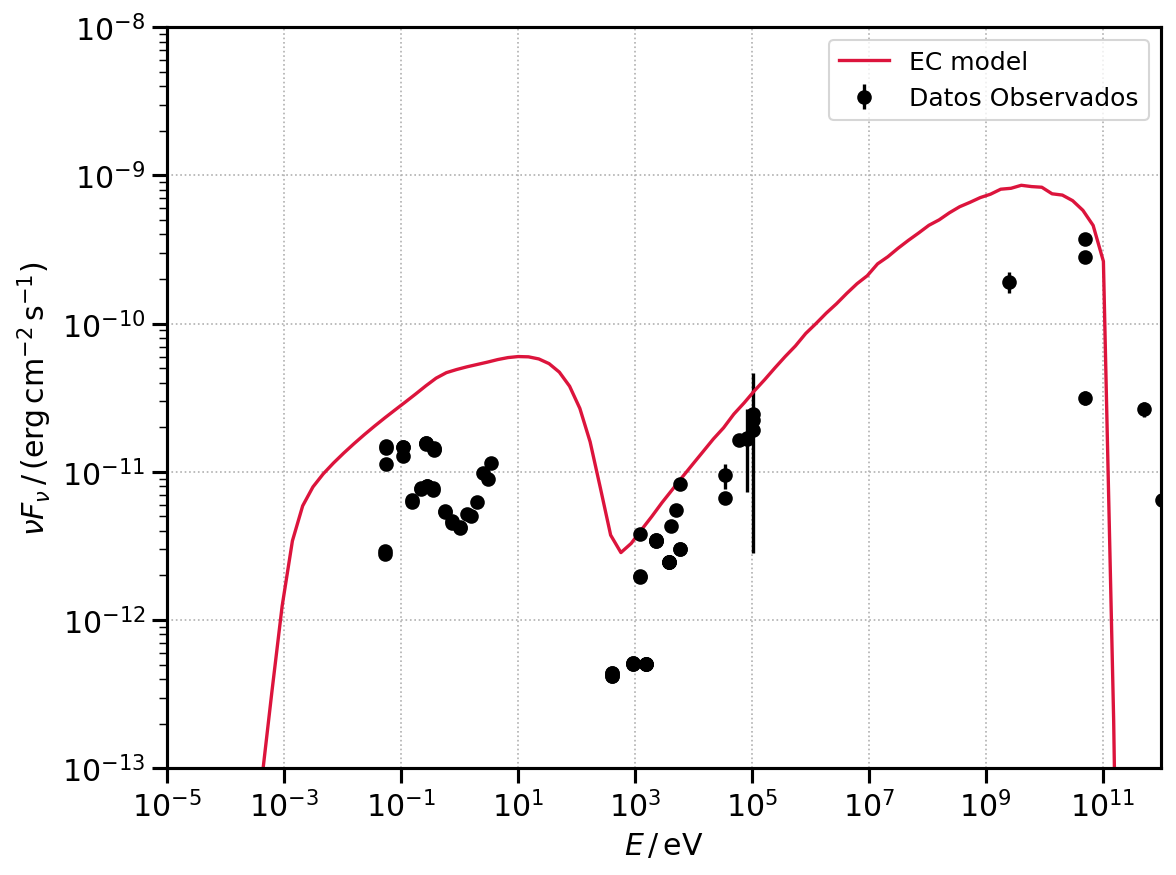

In [8]:
#Array de energías para graficar el modelo
E = np.logspace(np.log10(E_min), np.log10(E_max), 100)  # ya en eV

#Grafica
fig, ax = plt.subplots(figsize=(8, 6))

# Datos observacionales
ax.errorbar(
    energy_eV,
    flux_erg_cm2_s,
    yerr=flux_err_total,
    marker="o",
    ls="",
    color="k",
    label="Datos Observados",
)

#Modelo inicial
ax.loglog(E, ec_model(E), ls="-", color="crimson", label="EC model")

#Estética de la gráfica
ax.set_ylabel(sed_y_label)
ax.set_xlabel(r"$E\,/\,{\rm eV}$")
ax.set_xlim([1e-5, 1e12])
ax.set_ylim([1e-13, 1e-8])
ax.legend()
plt.show()

## Run the Fit:

In [9]:
from sherpa.data import Data1D

#Creamos el dataset de sherpa
data = Data1D("PKS1222_obs", energy_eV, flux_erg_cm2_s, staterror=flux_err_total)

#Ahora definimos el ajuste
fitter = Fit(data, ec_model, stat=Chi2(), method=LevMar())

# Ejecutar el fit
%time
results = fitter.fit()

#Vemos los resultados
print("Fit successful = ", results.succeeded)
print(results.format())

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 5.48 μs
Fit successful =  True
Method                = levmar
Statistic             = chi2
Initial fit statistic = nan
Final fit statistic   = nan at function evaluation 8
Data points           = 76
Degrees of freedom    = 69
Probability [Q-value] = nan
Reduced statistic     = nan
Change in statistic   = nan
   ec.log10_k     0.371068     +/- nan         
   ec.p           2            +/- nan         
   ec.q           0.2          +/- nan         
   ec.delta_D     25           +/- nan         
   ec.log10_B     -0.455932    +/- nan         
   ec.mu_s        0.999222     +/- nan         
   ec.log10_r     17.7782      +/- nan         


### Calculamos algunos parámetros:

In [11]:
#Factor de Lorentz del Jet:
calcular_Gamma_efectivo(ec_model)


Gamma efectivo después del ajuste: 24.99


np.float64(24.989999890147498)

In [14]:
#Campo Magnético:
Campo_B=10**(-0.455932)
Campo_B

0.3499999642579026

In [15]:
#Parámetro de normalización:
k=10**(0.371068)
k

2.3500007452580784

In [16]:
#Región de emisión:
Rb=10**(17.7782)
Rb

6.000673538641139e+17